In [1]:
import pandas as pd
from prophet import Prophet
from datetime import datetime, timedelta
from collections import deque
import numpy as np
import math
import time
import altair as alt
#from neuralprophet import NeuralProphet

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from orbit.utils.simulation import make_trend, make_seasonality, make_regression

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [8, 8]

%matplotlib inline

import pandas as pd
import random
random.seed()

myfreq = "1MIN" # "D" or "1MIN"
if myfreq == "1MIN":
    xs = pd.date_range("00:00", "23:59", freq=myfreq)
elif myfreq == "D":
    xs = pd.date_range(start='1/1/2018', end='1/1/2022', freq=myfreq)
else:
    xs = pd.date_range(start='1/1/1818', end='1/1/2122', freq=myfreq)
xs

DatetimeIndex(['2021-09-07 00:00:00', '2021-09-07 00:01:00',
               '2021-09-07 00:02:00', '2021-09-07 00:03:00',
               '2021-09-07 00:04:00', '2021-09-07 00:05:00',
               '2021-09-07 00:06:00', '2021-09-07 00:07:00',
               '2021-09-07 00:08:00', '2021-09-07 00:09:00',
               ...
               '2021-09-07 23:50:00', '2021-09-07 23:51:00',
               '2021-09-07 23:52:00', '2021-09-07 23:53:00',
               '2021-09-07 23:54:00', '2021-09-07 23:55:00',
               '2021-09-07 23:56:00', '2021-09-07 23:57:00',
               '2021-09-07 23:58:00', '2021-09-07 23:59:00'],
              dtype='datetime64[ns]', length=1440, freq='T')

In [2]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']
    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = 1

    #anomaly importances
    '''
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] == 1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    '''
    
    return forecasted
def plot_anomalies(forecasted, mytitle='Anomaly Detection'):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T', axis=alt.Axis(format='%H:%M'), title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title=mytitle
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='CPU Utilization Percentage'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='CPU Utilization Percentage'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)

,ds,y
0,2021-09-07 00:00:00,6.395254
1,2021-09-07 00:01:00,6.499015
2,2021-09-07 00:02:00,6.489431
3,2021-09-07 00:03:00,6.545597
4,2021-09-07 00:04:00,6.173922
...,...,...
1435,2021-09-07 23:55:00,3.766102
1436,2021-09-07 23:56:00,3.702306
1437,2021-09-07 23:57:00,3.704043
1438,2021-09-07 23:58:00,3.668765


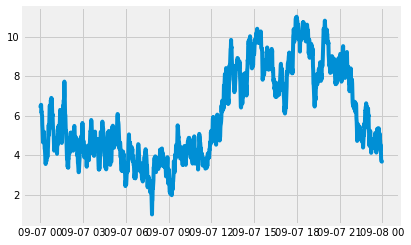

In [228]:
## generate random data

multiplier = 10

## random walk
rw = make_trend(len(xs), rw_loc=0.01, rw_scale=1, seed=random.randint(1, 2000))
# normalize [0, 1.5]
y= 1 + (multiplier*(rw - np.min(rw))/np.ptp(rw))
_ = plt.plot(xs, y)

# # fourier
# fs = make_seasonality(len(xs), seasonality=random.randint(100, 1000), method='fourier', order=random.randint(4, 10), seed=random.randint(1, 2000))
# y = 1 + (multiplier*(fs - np.min(fs))/np.ptp(fs))
# _ = plt.plot(y)

# # arma
# arma_trend =  make_trend(len(xs), method='arma', arma=[.8, -.1], seed=random.randint(1, 2000))
# # normalize [0, 1.5]
# y = (multiplier*(arma_trend - np.min(arma_trend))/np.ptp(arma_trend))
# _ = plt.plot(xs, y)

# discrete
# ds = make_seasonality(len(xs), seasonality=random.randint(20, 50), duration=random.randint(2, 50), method='discrete', seed=random.randint(1, 2000))
# y = (multiplier*(ds - np.min(ds))/np.ptp(ds))
# _ = plt.plot(xs, y)

## Anomaly

df = pd.DataFrame({"ds" : xs, "y" : y})
df

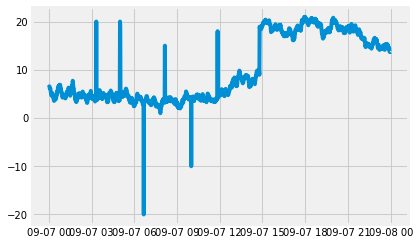

In [229]:
y[200] = 20
y[300] = 20
y[301] = 19
y[400] = -20
y[489] = 15
y[600] = -10
y[711] = 18

for xx in range(888, len(y)):
    y[xx] = y[xx] + 10
_ = plt.plot(xs, y)

In [230]:
def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values - average) ** 2, weights=weights)
    return average, math.sqrt(variance)
def compute_vol(metrics_ds):
    cumulative_metrics_data = np.array(metrics_ds)
    vol = np.std(cumulative_metrics_data) / np.mean(cumulative_metrics_data[:10])
    time_steps = cumulative_metrics_data.shape[0]
    weights = np.flip(np.true_divide(np.arange(1, time_steps + 1), time_steps))
    weighted_mean, weighted_std = weighted_avg_and_std(cumulative_metrics_data, weights)
    weighted_vol = weighted_std / weighted_mean
    return  weighted_vol
    

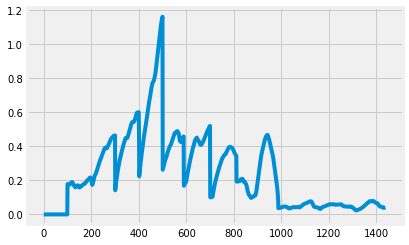

In [231]:
crd = []
v = [0] * 100
s = 50
for i in range(100, len(y)):
    thisy = y[i-100 : i]
    thisv = compute_vol(thisy)
    v.append(thisv)
    if thisv >= 0.20:
        crd.append((i ,thisv))
        #s = i
plt.plot(v)

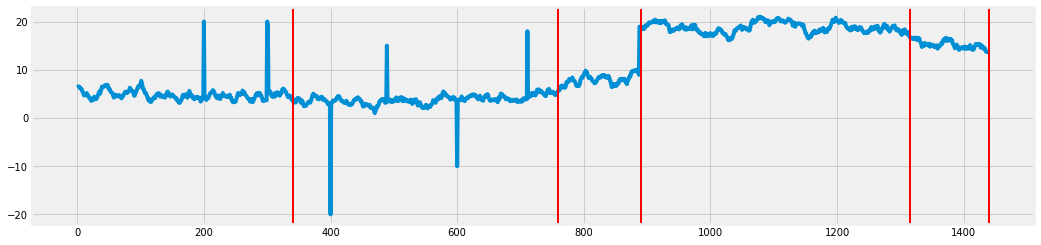

In [232]:
import ruptures as rpt
# offline CPD method. 

mydf = pd.Series(y, xs)

algo1 = rpt.Pelt(model="rbf").fit(y)
change_location1 = algo1.predict(pen=10)

# Point the change points:
def plot_change_points(ts,ts_change_loc):
    plt.figure(figsize=(16,4))
    plt.plot(ts)
    for x in ts_change_loc:
        plt.axvline(x,lw=2, color='red')

plot_change_points(y,change_location1)

In [233]:
change_location1


[340, 760, 890, 1315, 1440]

In [214]:
len(y[850:])

590

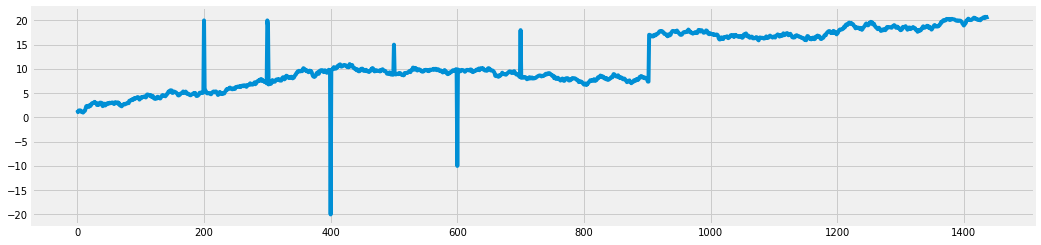

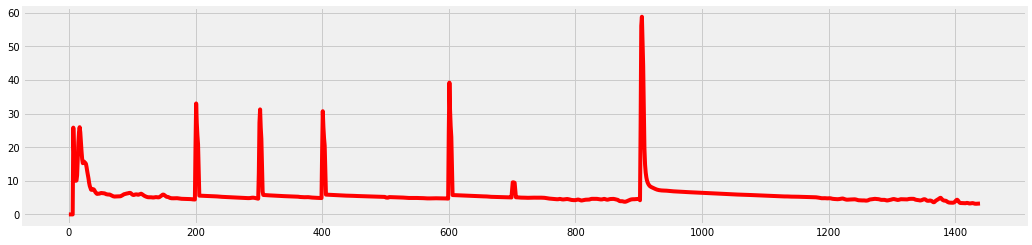

In [191]:
import changefinder
# https://github.com/shunsukeaihara/changefinder/blob/master/changefinder/__init__.py
# online CPD. however it looks more like an outlier detector.

def findChangePoints(ts, r, order, smooth):
    '''
       r: Discounting rate
       order: AR model order
       smooth: smoothing window size T
    '''
    cf = changefinder.ChangeFinder(r=r, order=order, smooth=smooth)
    ts_score = [cf.update(p) for p in ts]
    plt.figure(figsize=(16,4))
    plt.plot(ts)
    plt.figure(figsize=(16,4))
    plt.plot(ts_score, color='red')
    return(ts_score)
    
y_score1 = findChangePoints(y, r = 0.01, order = 1, smooth = 5)

In [192]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

%matplotlib inline
mydf = pd.Series(y, xs)

## shared parameters among different models

max_interval = 1440 # max training time interval
one_step_len = 5 ## re-fit model every five steps
n_loops = (len(mydf) // one_step_len) - 1
confidence_interval_level = 2.57 ## 1 for 68%, 2 for 95% and 3 standard deviation for 99.7%. use 3 or 2
## SARIMAX model fit

from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels as sm
# mydf2, mytest = mydf[:1000], mydf[1000:1010]
# model = SARIMAX(mydf2, order=(1,1,1))
# model_fit = model.fit(disp=0)
# res = model_fit.get_forecast(10, alpha=0.05)
# res.conf_int()
# res1 = model_fit.forecast(10, alpha=0.05)
# res1
# fc_series = pd.Series(fc, index=mytest.index)
# lower_series = pd.Series(conf[:, 0], index=mytest.index)
# upper_series = pd.Series(conf[:, 1], index=mytest.index)

print(n_loops)
fcall = None
lowerall = None
upperall = None

for i1 in range(10, n_loops): # 39 for normal period and 59 for all
    i = i1 * one_step_len
    mydf1, mytest = mydf[0:i+one_step_len].copy(), mydf[i+one_step_len: i + one_step_len*2].copy() # no max interval
    order = (1,1,1)
    seasonal_order= (0,0,0,0)
    enforce_stationarity = True
    myfit = SARIMAX(mydf1,enforce_stationarity=enforce_stationarity, order=order, seasonal_order=seasonal_order).fit(disp=False)

    #alpha = 0.003 if confidence_interval_level == 3 else 0.05 if confidence_interval_level == 2 else 0.32
    alpha = 0.01
    fc_series = myfit.forecast(one_step_len)
    intervals = myfit.get_forecast(one_step_len).conf_int(alpha=alpha)
    lower_series, upper_series = intervals["lower y"], intervals["upper y"]
    
    if fcall is None:
        fcall = fc_series.copy()
        lowerall = lower_series.copy()
        upperall = upper_series.copy()
    else:
        fcall = pd.concat([fcall, fc_series.copy()])
        lowerall = pd.concat([lowerall, lower_series.copy()])
        upperall = pd.concat([upperall, upper_series.copy()])
        
        

287


/Users/tybalex/.pyenv/versions/3.8.6/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/tybalex/.pyenv/versions/3.8.6/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [193]:
## plot SARIMAX

tf1 = pd.DataFrame({"ds" : mydf.index, "yhat" : fcall, "yhat_lower" : lowerall, "yhat_upper" : upperall, "fact" : mydf})
detected_anomalies = detect_anomalies(tf1)
plot_anomalies(detected_anomalies, mytitle="SARIMAX Anomaly Detection")

alt.LayerChart(...)